In [1]:
import json
import pandas as pd
from pathlib import Path
from pprint import pprint
import datetime
import time
import numpy as np
import matplotlib as plt

import pandas
import researchpy as rp
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

%matplotlib inline

In [2]:
#path_results = Path('/media/discoD/models/elmo/ner/results_20_epochs_ibm')
#path_results = Path('/media/discoD/models/elmo/ner/results_1_epoch_harem_all_combinations')
path_results = Path('/media/discoD/models/elmo/ner/mestrado/results_harem_rtx2080ti/')

In [3]:
for folder in path_results.iterdir():
    print(folder)

/media/discoD/models/elmo/ner/mestrado/results_harem_rtx2080ti/harem-ft1epoch_ELMo
/media/discoD/models/elmo/ner/mestrado/results_harem_rtx2080ti/harem-ft1epoch_ELMo+CNN
/media/discoD/models/elmo/ner/mestrado/results_harem_rtx2080ti/harem-ft1epoch_ELMo+CNN+Embeddings
/media/discoD/models/elmo/ner/mestrado/results_harem_rtx2080ti/harem-ft1epoch_ELMo+Embeddings
/media/discoD/models/elmo/ner/mestrado/results_harem_rtx2080ti/harem-ft_ELMo
/media/discoD/models/elmo/ner/mestrado/results_harem_rtx2080ti/harem-ft_ELMo+CNN
/media/discoD/models/elmo/ner/mestrado/results_harem_rtx2080ti/harem-ft_ELMo+CNN+Embeddings
/media/discoD/models/elmo/ner/mestrado/results_harem_rtx2080ti/harem-ft_ELMo+Embeddings
/media/discoD/models/elmo/ner/mestrado/results_harem_rtx2080ti/harem-wikibrwac-ft_ELMo
/media/discoD/models/elmo/ner/mestrado/results_harem_rtx2080ti/harem-wikibrwac-ft_ELMo+CNN
/media/discoD/models/elmo/ner/mestrado/results_harem_rtx2080ti/harem-wikibrwac-ft_ELMo+CNN+Embeddings
/media/discoD/models

In [4]:
configs = dict()
metrics = dict()
for model_folder in path_results.iterdir():
    if 'Embeddings' in model_folder.name:
        #print('Reading embeddings folder from %s' % model_folder.name)
        for embedding_folder in model_folder.iterdir():
            #print('Reading trainings folder from %s' % embedding_folder.name)
            for training_folder in embedding_folder.iterdir():
                key = embedding_folder.name + '_' + training_folder.name
                #print('Reading files from %s' % key)
                has_metrics = False
                for results_file in training_folder.iterdir():
                    if results_file.name.endswith('.json'):
                        #print('Parsing data from %s' % results_file.name)
                        if results_file.name.startswith('config'):
                            configs[key] = json.loads(results_file.read_bytes())
                        elif results_file.name.startswith('metrics.'):
                            metrics[key] = json.loads(results_file.read_bytes())
                            has_metrics = True
                if not has_metrics:
                    print('metrics.json not found for %s' % key)
                    del configs[key]
    else:
        #print('Reading trainings folder from %s' % model_folder.name)
        for training_folder in model_folder.iterdir():
            key = training_folder.name
            #print('Reading files from %s' % key)
            has_metrics = False
            for results_file in training_folder.iterdir():
                if results_file.name.endswith('.json'):
                    #print('Parsing data from %s' % results_file.name)
                    if results_file.name.startswith('config'):
                        configs[key] = json.loads(results_file.read_bytes())
                    elif results_file.name.startswith('metrics.'):
                        metrics[key] = json.loads(results_file.read_bytes())
                        has_metrics = True
            if not has_metrics:
                print('metrics.json not found for %s' % key)
                del configs[key]
print(len(metrics))
print(len(configs))

metrics.json not found for harem-ft1epoch_ELMo+Embeddings_fasttext_cbow_1_0
metrics.json not found for harem-wikibrwac-ft_ELMo_0_0
metrics.json not found for harem-wikibrwac-ft_ELMo+CNN_0_0
metrics.json not found for harem-wikibrwac-ft_ELMo+CNN+Embeddings_fasttext_cbow_0_0
metrics.json not found for harem-wikibrwac-ft_ELMo+CNN+Embeddings_fasttext_skip_0_0
metrics.json not found for harem-wikibrwac-ft_ELMo+CNN+Embeddings_glove_glove_0_0
metrics.json not found for harem-wikibrwac-ft_ELMo+CNN+Embeddings_wang2vec_cbow_0_0
metrics.json not found for harem-wikibrwac-ft_ELMo+CNN+Embeddings_wang2vec_skip_0_0
metrics.json not found for harem-wikibrwac-ft_ELMo+CNN+Embeddings_word2vec_cbow_0_0
metrics.json not found for harem-wikibrwac-ft_ELMo+CNN+Embeddings_word2vec_skip_0_0
metrics.json not found for harem-wikibrwac-ft_ELMo+Embeddings_fasttext_cbow_0_0
metrics.json not found for harem-wikibrwac-ft_ELMo+Embeddings_fasttext_skip_0_0
metrics.json not found for harem-wikibrwac-ft_ELMo+Embeddings_gl

In [5]:
def get_seconds(time_str):
    x = time.strptime(time_str.split('.')[0],'%H:%M:%S')
    return datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()
def get_average_epoch_duration(metrics):
    seconds = get_seconds(metrics['training_duration'])
    training_epochs = metrics['training_epochs'] + 1
    return seconds / training_epochs

In [6]:
TRAINING_ID = 'Training_ID'
SCENARIO = 'Scenario'
MODEL = 'Model'
REPRESENTATION = 'Representation'
EMBEDDING = 'Embedding'
EMBEDDING_TYPE = 'Embedding_Type'
BATCH_SIZE = 'Batch_Size'
ELMO_DROPOUT = 'ELMo_Dropout'
TRAINING_NUMBER = 'Training_Number'
EXECUTION_NUMBER = 'Execution_Number'
BEST_EPOCH = 'Best_Epoch'
TRAINING_EPOCHS = 'Training_Epochs'
TRAINING_DURATION = 'Training_Duration'
TOTAL_DURATION = 'Total_Duration(s)'
AVERAGE_EPOCH_DURATION = 'Average_Epoch_Duration(s)'
TRAINING_ACCURACY = 'Training_Accuracy'
TRAINING_ACCURACY_TOP3 = 'Training_Accuracy_Top-3'
TRAINING_PRECISION = 'Training_Precision'
TRAINING_RECALL = 'Training_Recall'
TRAINING_F1_MEASURE = 'Training_F1-Measure'
TRAINING_LOSS = 'Training_Loss'
BEST_VALIDATION_ACCURACY = 'Best_Validation_Accuracy'
BEST_VALIDATION_ACCURACY_TOP3 = 'Best_Validation_Accuracy_Top-3'
BEST_VALIDATION_PRECISION = 'Best_Validation_Precision'
BEST_VALIDATION_RECALL = 'Best_Validation_Recall'
BEST_VALIDATION_F1_MEASURE = 'Best_Validation_F1-Measure'
BEST_VALIDATION_LOSS = 'Best_Validation_Loss'
TEST_ACCURACY = 'Test_Accuracy'
TEST_ACCURACY_TOP3 = 'Test_Accuracy_Top-3'
TEST_PRECISION = 'Test_Precision'
TEST_RECALL = 'Test_Recall'
TEST_F1_MEASURE = 'Test_F1_Measure'
TEST_LOSS = 'Test_Loss'
columns = [TRAINING_ID, MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE, TRAINING_NUMBER, EXECUTION_NUMBER, BEST_EPOCH, TRAINING_EPOCHS, TRAINING_DURATION, TOTAL_DURATION, AVERAGE_EPOCH_DURATION, TRAINING_ACCURACY, TRAINING_ACCURACY_TOP3, TRAINING_PRECISION, TRAINING_RECALL, TRAINING_F1_MEASURE, TRAINING_LOSS, BEST_VALIDATION_ACCURACY, BEST_VALIDATION_ACCURACY_TOP3, BEST_VALIDATION_PRECISION, BEST_VALIDATION_RECALL, BEST_VALIDATION_F1_MEASURE, BEST_VALIDATION_LOSS, TEST_ACCURACY, TEST_ACCURACY_TOP3, TEST_PRECISION, TEST_RECALL, TEST_F1_MEASURE, TEST_LOSS]
columns

['Training_ID',
 'Model',
 'Representation',
 'Embedding',
 'Embedding_Type',
 'Training_Number',
 'Execution_Number',
 'Best_Epoch',
 'Training_Epochs',
 'Training_Duration',
 'Total_Duration(s)',
 'Average_Epoch_Duration(s)',
 'Training_Accuracy',
 'Training_Accuracy_Top-3',
 'Training_Precision',
 'Training_Recall',
 'Training_F1-Measure',
 'Training_Loss',
 'Best_Validation_Accuracy',
 'Best_Validation_Accuracy_Top-3',
 'Best_Validation_Precision',
 'Best_Validation_Recall',
 'Best_Validation_F1-Measure',
 'Best_Validation_Loss',
 'Test_Accuracy',
 'Test_Accuracy_Top-3',
 'Test_Precision',
 'Test_Recall',
 'Test_F1_Measure',
 'Test_Loss']

In [7]:
def get_training_data_from_id(training_id, config):
    data = training_id.split('_')
    print(data)
    if len(data) == 4:
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: 'No', EMBEDDING_TYPE: 'No', TRAINING_NUMBER: data[2], EXECUTION_NUMBER: data[3]}
    elif len(data) == 5:
        #GloVe
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: 'No', TRAINING_NUMBER: data[3], EXECUTION_NUMBER: data[4]}
    elif len(data) == 6:
        embedding_type = data[3] if data[2] != 'glove' else 'No'
        return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: embedding_type, TRAINING_NUMBER: data[4], EXECUTION_NUMBER: data[5]}
    else:
        print('Check id: %s' % training_id)

In [8]:
training_data = []
for training_id, config in configs.items():
    training_metrics = metrics[training_id]
    data = get_training_data_from_id(training_id, config)
    data[TRAINING_ID] = training_id
    data[BEST_EPOCH] = training_metrics['best_epoch'] if training_metrics else None
    data[TRAINING_EPOCHS] = training_metrics['training_epochs'] + 1 if training_metrics else None
    data[TRAINING_DURATION] = training_metrics['training_duration'] if training_metrics else None
    data[TOTAL_DURATION] = get_seconds(training_metrics['training_duration']) if training_metrics else None
    data[AVERAGE_EPOCH_DURATION] = get_average_epoch_duration(training_metrics) if training_metrics else None
    data[TRAINING_ACCURACY] = training_metrics['training_accuracy'] if training_metrics else None
    data[TRAINING_ACCURACY_TOP3] = training_metrics['training_accuracy3'] if training_metrics else None
    data[TRAINING_PRECISION] = training_metrics['training_precision-overall'] if training_metrics else None
    data[TRAINING_RECALL] = training_metrics['training_recall-overall'] if training_metrics else None
    data[TRAINING_F1_MEASURE] = training_metrics['training_f1-measure-overall'] if training_metrics else None
    data[TRAINING_LOSS] = training_metrics['training_loss'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY] = training_metrics['best_validation_accuracy'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY_TOP3] = training_metrics['best_validation_accuracy3'] if training_metrics else None
    data[BEST_VALIDATION_PRECISION] = training_metrics['best_validation_precision-overall'] if training_metrics else None
    data[BEST_VALIDATION_RECALL] = training_metrics['best_validation_recall-overall'] if training_metrics else None
    data[BEST_VALIDATION_F1_MEASURE] = training_metrics['best_validation_f1-measure-overall'] if training_metrics else None
    data[BEST_VALIDATION_LOSS] = training_metrics['best_validation_loss'] if training_metrics else None
    data[TEST_ACCURACY] = training_metrics['test_accuracy'] if training_metrics else None
    data[TEST_ACCURACY_TOP3] = training_metrics['test_accuracy3'] if training_metrics else None
    data[TEST_PRECISION] = training_metrics['test_precision-overall'] if training_metrics else None
    data[TEST_RECALL] = training_metrics['test_recall-overall'] if training_metrics else None
    data[TEST_F1_MEASURE] = training_metrics['test_f1-measure-overall'] if training_metrics else None
    data[TEST_LOSS] = training_metrics['test_loss'] if training_metrics else None
    training_data.append(data)

['harem-ft1epoch', 'ELMo', '0', '0']
['harem-ft1epoch', 'ELMo+CNN', '0', '0']
['harem-ft1epoch', 'ELMo+CNN', '1', '0']
['harem-ft1epoch', 'ELMo+CNN+Embeddings', 'fasttext', 'cbow', '0', '0']
['harem-ft1epoch', 'ELMo+CNN+Embeddings', 'fasttext', 'cbow', '1', '0']
['harem-ft1epoch', 'ELMo+CNN+Embeddings', 'fasttext', 'skip', '0', '0']
['harem-ft1epoch', 'ELMo+CNN+Embeddings', 'fasttext', 'skip', '1', '0']
['harem-ft1epoch', 'ELMo+CNN+Embeddings', 'glove', 'glove', '0', '0']
['harem-ft1epoch', 'ELMo+CNN+Embeddings', 'glove', 'glove', '1', '0']
['harem-ft1epoch', 'ELMo+CNN+Embeddings', 'wang2vec', 'cbow', '0', '0']
['harem-ft1epoch', 'ELMo+CNN+Embeddings', 'wang2vec', 'cbow', '1', '0']
['harem-ft1epoch', 'ELMo+CNN+Embeddings', 'wang2vec', 'skip', '0', '0']
['harem-ft1epoch', 'ELMo+CNN+Embeddings', 'wang2vec', 'skip', '1', '0']
['harem-ft1epoch', 'ELMo+CNN+Embeddings', 'word2vec', 'cbow', '0', '0']
['harem-ft1epoch', 'ELMo+CNN+Embeddings', 'word2vec', 'cbow', '1', '0']
['harem-ft1epoch', 'E

In [9]:
pd.set_option('display.max_columns', 1000)
training_data_df = pd.DataFrame(training_data, columns=columns)
#training_data_df = training_data_df[(training_data_df[TRAINING_NUMBER]).astype(int) < 9]
training_data_df 

,Training_ID,Model,Representation,Embedding,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
0,harem-ft1epoch_ELMo_0_0,harem-ft1epoch,ELMo,No,No,0,0,0,1,0:00:29.451287,29.0,29.0,0.903352,0.910920,0.077200,0.052050,0.062178,674.734905,0.943176,0.949295,0.447826,0.262755,0.331190,253.059298,0.941884,0.947857,0.491995,0.266778,0.345962,289.968179
1,harem-ft1epoch_ELMo+CNN_0_0,harem-ft1epoch,ELMo+CNN,No,No,0,0,0,1,0:00:33.709608,33.0,33.0,0.900251,0.907740,0.093927,0.067152,0.078314,673.334179,0.941646,0.948093,0.408163,0.255102,0.313972,242.499121,0.941028,0.947212,0.460712,0.272120,0.342149,282.358763
2,harem-ft1epoch_ELMo+CNN_1_0,harem-ft1epoch,ELMo+CNN,No,No,1,0,0,1,0:00:33.705148,33.0,33.0,0.898556,0.906245,0.094292,0.070218,0.080493,671.641321,0.953197,0.958275,0.441281,0.323760,0.373494,220.686996,0.940548,0.947092,0.429931,0.271452,0.332788,281.371202
3,harem-ft1epoch_ELMo+CNN+Embeddings_fasttext_cb...,harem-ft1epoch,ELMo+CNN+Embeddings,fasttext,cbow,0,0,0,1,0:00:34.670706,34.0,34.0,0.902244,0.909845,0.218833,0.044498,0.073958,659.442064,0.943503,0.949842,0.349544,0.293367,0.319001,242.432016,0.943265,0.949614,0.421213,0.322204,0.365115,276.441831
4,harem-ft1epoch_ELMo+CNN+Embeddings_fasttext_cb...,harem-ft1epoch,ELMo+CNN+Embeddings,fasttext,cbow,1,0,0,1,0:00:35.095611,35.0,35.0,0.901179,0.908993,0.226744,0.041969,0.070829,658.887560,0.952798,0.957877,0.364179,0.318538,0.339833,226.329739,0.941388,0.948008,0.408145,0.301169,0.346590,284.151383
5,harem-ft1epoch_ELMo+CNN+Embeddings_fasttext_sk...,harem-ft1epoch,ELMo+CNN+Embeddings,fasttext,skip,0,0,0,1,0:00:34.229241,34.0,34.0,0.908188,0.915611,0.294805,0.061219,0.101385,636.919080,0.944159,0.950060,0.425373,0.290816,0.345455,233.220642,0.943310,0.948473,0.483871,0.300501,0.370752,271.948318
6,harem-ft1epoch_ELMo+CNN+Embeddings_fasttext_sk...,harem-ft1epoch,ELMo+CNN+Embeddings,fasttext,skip,1,0,0,1,0:00:34.413873,34.0,34.0,0.907014,0.914591,0.292191,0.062416,0.102860,625.699487,0.954093,0.958972,0.426667,0.334204,0.374817,209.541735,0.943430,0.949148,0.462155,0.307846,0.369539,267.574220
7,harem-ft1epoch_ELMo+CNN+Embeddings_glove_glove...,harem-ft1epoch,ELMo+CNN+Embeddings,glove,No,0,0,0,1,0:00:34.574006,34.0,34.0,0.908916,0.916405,0.302993,0.065534,0.107761,631.916935,0.945361,0.950934,0.448148,0.308673,0.365559,226.199124,0.944660,0.950034,0.521368,0.325876,0.401068,262.837869
8,harem-ft1epoch_ELMo+CNN+Embeddings_glove_glove...,harem-ft1epoch,ELMo+CNN+Embeddings,glove,No,1,0,0,1,0:00:35.000747,35.0,35.0,0.907749,0.915303,0.302239,0.065375,0.107498,624.087340,0.955188,0.959968,0.436667,0.342037,0.383602,207.070728,0.944180,0.949734,0.484248,0.318197,0.384042,264.679427
9,harem-ft1epoch_ELMo+CNN+Embeddings_wang2vec_cb...,harem-ft1epoch,ELMo+CNN+Embeddings,wang2vec,cbow,0,0,0,1,0:00:34.575901,34.0,34.0,0.908905,0.916193,0.307995,0.063376,0.105122,638.121361,0.946235,0.951590,0.502058,0.311224,0.384252,232.426153,0.944075,0.949373,0.532324,0.305175,0.387946,268.827970


In [10]:
training_data_df[training_data_df.Embedding_Type == 'glove']

,Training_ID,Model,Representation,Embedding,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss


In [11]:
#training_data_df.to_csv('training_data_5_epochs_mestrado_all_reps.csv', index=None)

In [12]:
str(datetime.timedelta(seconds=training_data_df[TOTAL_DURATION].mean()))

'0:00:32.378947'

In [13]:
default_exported_columns = ['mean', 'min', 'max', 'std']
renamed_columns = ['Contagem', 'F-Score', 'Desvio Padrão', 'Mínimo', '25%', '50%', '75%', 'Máximo']
exported_columns_names = ['F-Score', 'Mínimo', 'Máximo', 'Desvio Padrão']
model_map = {'harem-ft': 'Sim', 'harem': 'Não'}
representation_map = {'ELMo+CNN+Embeddings': 'ELMo+CNN+Vetor', 'ELMo+Embeddings': 'ELMo+Vetor'}
embedding_type_map = {'skip': 'Skip-Gram', 'No': 'Sem Vetor', 'cbow': 'CBoW'}
embedding_map = {'wang2vec': 'Wang2Vec', 'glove': 'GloVe', 'word2vec': 'Word2Vec', 'No': 'Sem Vetor', 'fasttext': 'FastText'}
replacements_map = {**model_map, **representation_map, **embedding_type_map, **embedding_map}

def get_group_csv(index_names, group_name, group_columns, target_value, index_map, dataframe=training_data_df, exported_columns=default_exported_columns):
    if type(index_names) == str:
        index_names = [index_names]
    group = dataframe.groupby(group_columns).describe()[target_value].sort_values(by='mean', ascending=False)
    for column in exported_columns:
        group[column] = group[column] * 100
    group.index.names = index_names
    group = group.rename(index=index_map)
    group.columns = renamed_columns
    #group.to_csv('grupo_' + group_name + '_5_epochs_mestrado_all_reps.csv', columns=exported_columns_names, float_format = '%.2f%%')
    return group

In [32]:
training_data_df.groupby(MODEL).describe()[TEST_F1_MEASURE]

,count,mean,std,min,25%,50%,75%,max
Model,,,,,,,,
harem,32.0,0.416025,0.037317,0.350485,0.385142,0.410080,0.448414,0.471629
harem-ft,32.0,0.403788,0.040833,0.316592,0.387815,0.405664,0.436404,0.468462
harem-ft1epoch,24.0,0.372922,0.018698,0.332788,0.367276,0.376029,0.380300,0.420938
harem-wikibrwac,7.0,0.389920,0.013587,0.373867,0.379564,0.392590,0.396168,0.411521


In [14]:
get_group_csv('Ajuste Fino', MODEL, MODEL, TEST_F1_MEASURE, model_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Ajuste Fino,,,,,,,,
Não,32.0,41.602539,3.731693,35.048503,0.385142,0.410080,0.448414,47.162916
Sim,32.0,40.378796,4.083337,31.659175,0.387815,0.405664,0.436404,46.846168
harem-wikibrwac,7.0,38.992030,1.358674,37.386723,0.379564,0.392590,0.396168,41.152093
harem-ft1epoch,24.0,37.292189,1.869800,33.278756,0.367276,0.376029,0.380300,42.093824


In [15]:
get_group_csv('Representação', REPRESENTATION, REPRESENTATION, TEST_F1_MEASURE, representation_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Representação,,,,,,,,
ELMo+Vetor,35.0,42.516491,3.362861,36.222510,0.402631,0.435199,0.450538,47.162916
ELMo+CNN+Vetor,49.0,38.844053,2.317462,34.658982,0.373867,0.385204,0.397431,45.517507
ELMo,5.0,37.502396,5.783159,32.640710,0.333609,0.345962,0.408465,46.067633
ELMo+CNN,6.0,35.401950,4.211569,31.659175,0.322305,0.337469,0.387099,41.169545


In [16]:
get_group_csv('Tipo de Vetor', EMBEDDING_TYPE, EMBEDDING_TYPE, TEST_F1_MEASURE, embedding_type_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Tipo de Vetor,,,,,,,,
Skip-Gram,36.0,40.361966,3.491446,35.048503,0.373910,0.391879,0.438822,46.755247
CBoW,36.0,39.918534,3.164518,34.658982,0.377247,0.393173,0.411817,47.162916
Sem Vetor,23.0,39.185280,4.826743,31.659175,0.344056,0.401068,0.419559,46.846168


In [17]:
get_group_csv('Vetor', EMBEDDING, EMBEDDING, TEST_F1_MEASURE, embedding_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Vetor,,,,,,,,
GloVe,12.0,41.778146,3.153069,37.899073,0.393414,0.409668,0.439911,46.846168
Wang2Vec,24.0,40.554701,3.382785,35.048503,0.376338,0.397960,0.438836,46.974676
Word2Vec,24.0,40.510816,3.154035,36.799669,0.379017,0.393173,0.421705,47.162916
FastText,24.0,39.355233,3.403880,34.658982,0.367917,0.380744,0.424305,46.219631
Sem Vetor,11.0,36.356698,4.842506,31.659175,0.329597,0.342149,0.405273,46.067633


In [18]:
get_group_csv(['Ajuste Fino', 'Representação', 'Vetor', 'Tipo de Vetor'], 'Model_Rep_Emb_Emb-Typ', [MODEL, REPRESENTATION, EMBEDDING, EMBEDDING_TYPE], TEST_F1_MEASURE, replacements_map)

Contagem    F-Score  \
Ajuste Fino     Representação  Vetor     Tipo de Vetor                        
Não             ELMo+Vetor     Word2Vec  CBoW                2.0  46.420143   
Sim             ELMo+Vetor     GloVe     Sem Vetor           2.0  46.125377   
Não             ELMo+Vetor     Word2Vec  Skip-Gram           2.0  45.755649   
                               Wang2Vec  CBoW                2.0  45.557236   
                               FastText  Skip-Gram           2.0  44.946431   
                               GloVe     Sem Vetor           2.0  44.926732   
                               Wang2Vec  Skip-Gram           2.0  44.751117   
Sim             ELMo+Vetor     FastText  Skip-Gram           2.0  44.628575   
                               Wang2Vec  Skip-Gram           2.0  44.404263   
Não             ELMo           Sem Vetor Sem Vetor           2.0  43.457055   
                ELMo+Vetor     FastText  CBoW                2.0  43.019938   
Sim             ELMo+CNN+Vetor Wang2Vec  CBoW                2.0  42.630313   
                               Word2Vec  Skip-Gram           2.0  42.186343   
harem-ft1epoch  ELMo+Vetor     FastText  CBoW                1.0  42.093824   
Sim             ELMo+CNN+Vetor Wang2Vec  Skip-Gram           2.0  41.397195   
                ELMo+Vetor     Word2Vec  Skip-Gram           2.0  41.272802   
                ELMo+CNN+Vetor GloVe     Sem Vetor           2.0  41.175658   
harem-wikibrwac ELMo+CNN+Vetor GloVe     Sem Vetor           1.0  41.152093   
Sim             ELMo+Vetor     Wang2Vec  CBoW                2.0  40.788194   
                ELMo+CNN+Vetor Word2Vec  CBoW                2.0  40.739333   
                               FastText  Skip-Gram           2.0  40.728402   
Não             ELMo+CNN       Sem Vetor Sem Vetor           2.0  40.688859   
Sim             ELMo+Vetor     Word2Vec  CBoW                2.0  40.263146   
harem-wikibrwac ELMo+CNN+Vetor Wang2Vec  CBoW                1.0  39.933026   
Não             ELMo+CNN+Vetor GloVe     Sem Vetor           2.0  39.660010   
harem-wikibrwac ELMo+CNN+Vetor Word2Vec  CBoW                1.0  39.300583   
                                         Skip-Gram           1.0  39.258951   
harem-ft1epoch  ELMo+CNN+Vetor GloVe     Sem Vetor           2.0  39.255517   
Não             ELMo+CNN+Vetor Wang2Vec  CBoW                2.0  38.974898   
                               Word2Vec  Skip-Gram           2.0  38.779205   
harem-ft1epoch  ELMo+CNN+Vetor Wang2Vec  CBoW                2.0  38.642107   
Não             ELMo+CNN+Vetor Word2Vec  CBoW                2.0  38.544462   
harem-wikibrwac ELMo+CNN+Vetor FastText  CBoW                1.0  38.520408   
harem-ft1epoch  ELMo+Vetor     Word2Vec  Skip-Gram           1.0  38.456752   
Sim             ELMo+CNN+Vetor FastText  CBoW                2.0  38.024670   
harem-ft1epoch  ELMo+Vetor     Word2Vec  CBoW                1.0  37.905237   
                               GloVe     Sem Vetor           1.0  37.899073   
                               Wang2Vec  CBoW                1.0  37.634182   
                                         Skip-Gram           1.0  37.632840   
Não             ELMo+CNN+Vetor FastText  CBoW                2.0  37.535141   
harem-ft1epoch  ELMo+CNN+Vetor Word2Vec  Skip-Gram           2.0  37.518307   
harem-wikibrwac ELMo+CNN+Vetor Wang2Vec  Skip-Gram           1.0  37.392427   
                               FastText  Skip-Gram           1.0  37.386723   
harem-ft1epoch  ELMo+CNN+Vetor Word2Vec  CBoW                2.0  37.189644   
                               FastText  Skip-Gram           2.0  37.014544   
                               Wang2Vec  Skip-Gram           2.0  37.002432   
Sim             ELMo+Vetor     FastText  CBoW                2.0  36.925499   
harem-ft1epoch  ELMo+Vetor     FastText  Skip-Gram           1.0  36.885074   
Não             ELMo+CNN+Vetor FastText  Skip-Gram           2.0  36.411320   
                           

In [19]:
training_data_df.groupby([EMBEDDING, EMBEDDING_TYPE]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

count      mean       std       min       25%  \
Embedding Embedding_Type                                                  
glove     No               12.0  0.417781  0.031531  0.378991  0.393414   
wang2vec  cbow             12.0  0.408961  0.030284  0.376342  0.387183   
word2vec  skip             12.0  0.407284  0.030329  0.373143  0.384530   
          cbow             12.0  0.402933  0.033910  0.367997  0.378569   
wang2vec  skip             12.0  0.402133  0.038081  0.350485  0.373884   
fasttext  skip             12.0  0.401442  0.038555  0.353859  0.370449   
          cbow             12.0  0.385663  0.028290  0.346590  0.364866   
No        No               11.0  0.363567  0.048425  0.316592  0.329597   

                               50%       75%       max  
Embedding Embedding_Type                                
glove     No              0.409668  0.439911  0.468462  
wang2vec  cbow            0.398909  0.416931  0.469747  
word2vec  skip            0.397486  0.423072  0.467552  
          cbow            0.393173  0.412225  0.471629  
wang2vec  skip            0.384728  0.439499  0.450973  
fasttext  skip            0.382576  0.438956  0.462196  
          cbow            0.380744  0.402013  0.434532  
No        No              0.342149  0.405273  0.460676

In [20]:
training_data_skip_df = training_data_df[training_data_df[EMBEDDING_TYPE] != 'cbow']
training_data_skip_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
glove,12.0,0.417781,0.031531,0.378991,0.393414,0.409668,0.439911,0.468462
word2vec,12.0,0.407284,0.030329,0.373143,0.384530,0.397486,0.423072,0.467552
wang2vec,12.0,0.402133,0.038081,0.350485,0.373884,0.384728,0.439499,0.450973
fasttext,12.0,0.401442,0.038555,0.353859,0.370449,0.382576,0.438956,0.462196
No,11.0,0.363567,0.048425,0.316592,0.329597,0.342149,0.405273,0.460676


In [21]:
training_data_cbow_df = training_data_df[training_data_df[EMBEDDING_TYPE] != 'skip']
training_data_cbow_df.groupby([EMBEDDING]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Embedding,,,,,,,,
glove,12.0,0.417781,0.031531,0.378991,0.393414,0.409668,0.439911,0.468462
wang2vec,12.0,0.408961,0.030284,0.376342,0.387183,0.398909,0.416931,0.469747
word2vec,12.0,0.402933,0.033910,0.367997,0.378569,0.393173,0.412225,0.471629
fasttext,12.0,0.385663,0.028290,0.346590,0.364866,0.380744,0.402013,0.434532
No,11.0,0.363567,0.048425,0.316592,0.329597,0.342149,0.405273,0.460676


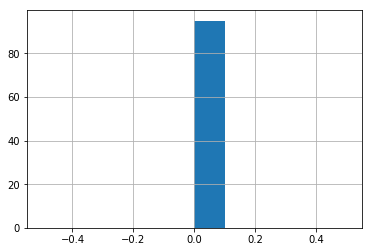

In [22]:
training_data_df[BEST_EPOCH].hist()

In [23]:
training_data_df[TOTAL_DURATION].describe()

count    95.000000
mean     32.378947
std       2.203377
min      29.000000
25%      30.000000
50%      34.000000
75%      34.000000
max      35.000000
Name: Total_Duration(s), dtype: float64

In [24]:
training_data_df.groupby([TRAINING_NUMBER]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Training_Number,,,,,,,,
0,55.0,0.401231,0.034611,0.318811,0.376307,0.395704,0.434674,0.468462
1,40.0,0.396148,0.041021,0.316592,0.367220,0.388084,0.419202,0.471629


In [25]:
rp.summary_cont(training_data_df[TEST_F1_MEASURE])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Test_F1_Measure,95.0,0.39909,0.037319,0.003829,0.391488,0.406693


In [26]:
rp.summary_cont(training_data_df.groupby(EMBEDDING))[TEST_F1_MEASURE]

,N,Mean,SD,SE,95% Conf.,Interval
Embedding,,,,,,
No,11,0.363567,0.048425,0.014601,0.334950,0.392184
fasttext,24,0.393552,0.034039,0.006948,0.379934,0.407171
glove,12,0.417781,0.031531,0.009102,0.399941,0.435622
wang2vec,24,0.405547,0.033828,0.006905,0.392013,0.419081
word2vec,24,0.405108,0.031540,0.006438,0.392489,0.417727


In [27]:
# Calculating effect size
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

def print_anova(parameter):
    # Fits the model with the interaction term
    # This will also automatically include the main effects for each factor
    model = ols('Test_F1_Measure ~ C({0})'.format(parameter), training_data_df).fit()
    # Seeing if the overall model is significant
    print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .20f}")
    print(model.summary())
    res = sm.stats.anova_lm(model, typ= 2)
    print(res)
    print(anova_table(res))
    mc = statsmodels.stats.multicomp.MultiComparison(training_data_df[TEST_F1_MEASURE], training_data_df[parameter])
    mc_results = mc.tukeyhsd()
    print(mc_results)

In [28]:
print_anova(EMBEDDING)

Overall model F( 4, 90) =  4.221, p =  0.00353918285309002059
                            OLS Regression Results                            
Dep. Variable:        Test_F1_Measure   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.121
Method:                 Least Squares   F-statistic:                     4.221
Date:                Tue, 13 Aug 2019   Prob (F-statistic):            0.00354
Time:                        09:36:29   Log-Likelihood:                 186.25
No. Observations:                  95   AIC:                            -362.5
Df Residuals:                      90   BIC:                            -349.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------

In [29]:
training_data_df[(training_data_df.Embedding == 'wang2vec') & (training_data_df.Embedding_Type == 'skip') & (training_data_df.Representation == 'ELMo+Embeddings')]

,Training_ID,Model,Representation,Embedding,Embedding_Type,Training_Number,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
21,harem-ft1epoch_ELMo+Embeddings_wang2vec_skip_0_0,harem-ft1epoch,ELMo+Embeddings,wang2vec,skip,0,0,0,1,0:00:30.352035,30.0,30.0,0.913853,0.921365,0.253281,0.052050,0.086353,644.112524,0.944924,0.950825,0.463320,0.306122,0.368664,236.513963,0.942859,0.949133,0.500554,0.301503,0.376328,269.591135
50,harem-ft_ELMo+Embeddings_wang2vec_skip_0_0,harem-ft,ELMo+Embeddings,wang2vec,skip,0,0,0,1,0:00:30.702230,30.0,30.0,0.913439,0.920738,0.240506,0.076861,0.116493,645.840536,0.949077,0.954978,0.480597,0.410714,0.442916,226.237671,0.949448,0.954927,0.517346,0.398331,0.450104,249.134498
51,harem-ft_ELMo+Embeddings_wang2vec_skip_1_0,harem-ft,ELMo+Embeddings,wang2vec,skip,1,0,0,1,0:00:30.874802,30.0,30.0,0.912114,0.919431,0.239676,0.079634,0.119548,647.053107,0.958574,0.963055,0.487342,0.402089,0.440629,191.488416,0.948128,0.953846,0.517524,0.379633,0.437982,249.271591
89,harem_ELMo+Embeddings_wang2vec_skip_0_0,harem,ELMo+Embeddings,wang2vec,skip,0,0,0,1,0:00:30.271449,30.0,30.0,0.914726,0.922037,0.300761,0.063916,0.105427,639.284856,0.950388,0.955633,0.494983,0.377551,0.428365,222.247940,0.948173,0.953876,0.542954,0.375626,0.444050,251.564742
90,harem_ELMo+Embeddings_wang2vec_skip_1_0,harem,ELMo+Embeddings,wang2vec,skip,1,0,0,1,0:00:30.627406,30.0,30.0,0.912906,0.920460,0.298920,0.066990,0.109451,637.150676,0.959968,0.964350,0.539216,0.430809,0.478955,195.675114,0.948668,0.954311,0.556045,0.379299,0.450973,251.679263
